In [170]:
import numpy as np
import pandas as pd
import fastf1
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load Silverstone track data
session = fastf1.get_session(2023, 'Silverstone', 'Q')
session.load()

lap = session.laps.pick_fastest()
# Get position data from the fastest lap
pos = lap.get_pos_data()

# Get circuit information
circuit_info = session.get_circuit_info()

# Access the corners DataFrame
corner_df = circuit_info.corners[['X', 'Y', 'Number']]


core           INFO 	Loading data for British Grand Prix - Qualifying [v3.4.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '55', '63', '44', '23', '14', '10', '27', '18', '31', '2', '77', '11', '22', '24', '21', '20']


In [330]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def calculate_fitted_lines(corner_x, corner_y, pos, max_points=10, extend_length=2000):
    """
    Calculate the fitted lines before and after a specified corner point.
    
    Parameters:
    - corner_x, corner_y: Coordinates of the corner point.
    - pos: DataFrame containing X and Y coordinates of track points.
    - max_points: Number of points to use for linear regression before and after the corner.
    - extend_length: Extension length for the fitted lines.
    
    Returns:
    - x_fit_before, y_fit_before: Extended fitted line coordinates before the corner.
    - x_fit_after, y_fit_after: Extended fitted line coordinates after the corner.
    - before_points, after_points: Points used for regression before and after the corner.
    """
    # Calculate the closest point to the corner in the data
    distances = np.sqrt((pos['X'] - corner_x) ** 2 + (pos['Y'] - corner_y) ** 2)
    corner_index = np.argmin(distances)

    # Get points before and after the corner
    before_points = pos.iloc[max(corner_index - max_points, 0):corner_index]
    after_points = pos.iloc[corner_index + 1:corner_index + max_points + 1]

    # Prepare data for linear regression
    X_before = before_points['X'].values.reshape(-1, 1)
    y_before = before_points['Y'].values
    X_after = after_points['X'].values.reshape(-1, 1)
    y_after = after_points['Y'].values

    # Adjust X values for each segment to pass through (x0, y0)
    x0, y0 = corner_x, corner_y
    adjusted_X_before = X_before - x0
    adjusted_X_after = X_after - x0

    # Fit a linear regression model for points before and after the corner
    model_before = LinearRegression()
    model_before.fit(adjusted_X_before, y_before)
    fitted_Y_before = model_before.coef_[0] * (X_before - x0) + y0

    model_after = LinearRegression()
    model_after.fit(adjusted_X_after, y_after)
    fitted_Y_after = model_after.coef_[0] * (X_after - x0) + y0

    x_before_far = before_points.iloc[0]['X']  # Point le plus éloigné dans before_points
    x_after_far = after_points.iloc[-1]['X'] 

    x_before_last = before_points.iloc[-1]['X']  # Dernier point dans before_points
    x_after_first = after_points.iloc[0]['X']    # Point le plus éloigné dans after_points

    # Extend the range of x_fit_before and x_fit_after further
    x_fit_before = np.linspace(x_before_far , x_before_last, 100).reshape(-1, 1)
    x_fit_after = np.linspace(x_after_far, x_after_first, 100).reshape(-1, 1)

    # Calculate the fitted lines with the constraint
    y_fit_before = model_before.coef_[0] * (x_fit_before - x0) + y0
    y_fit_after = model_after.coef_[0] * (x_fit_after - x0) + y0

    return x_fit_before, y_fit_before, x_fit_after, y_fit_after, before_points, after_points

def plot_corner_with_fitted_lines(pos, corner_x, corner_y, corner_number, x_fit_before, y_fit_before, x_fit_after, y_fit_after, before_points, after_points, show_points=False):
    """
    Plots a specific corner with fitted lines before and after, optionally displaying the points used to fit the lines.
    
    Parameters:
    - pos: DataFrame containing track positions with columns 'X' and 'Y'.
    - corner_x, corner_y: Coordinates of the corner.
    - corner_number: Number or identifier of the corner.
    - x_fit_before, y_fit_before: Arrays for the fitted line before the corner.
    - x_fit_after, y_fit_after: Arrays for the fitted line after the corner.
    - before_points, after_points: DataFrames of points used for the fitting.
    - show_points: Boolean flag to display the points used for fitting the lines.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(pos['X'], pos['Y'], color='lightgray', s=1, label='Track Points')
    plt.scatter(corner_x, corner_y, color='green', label=f'Corner {corner_number}', s=100, marker='X')
    plt.plot(x_fit_before, y_fit_before, color='cyan', linestyle='--', linewidth=2, label='Fitted Line Before Corner')
    plt.plot(x_fit_after, y_fit_after, color='magenta', linestyle='--', linewidth=2, label='Fitted Line After Corner')

    # Show the points used for fitting if show_points is True
    if show_points:
        plt.scatter(before_points['X'], before_points['Y'], color='blue', label='Points Before Corner', s=10)
        plt.scatter(after_points['X'], after_points['Y'], color='red', label='Points After Corner', s=10)

    plt.title(f'Selected Points and Fitted Lines Around Corner {corner_number}')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.axis('equal')
    plt.legend()
    plt.grid()
    plt.show()

def calculate_angle_between_lines(x_fit_before, y_fit_before, x_fit_after, y_fit_after):
    """
    Calculate the acute and obtuse angles between two lines defined by the points in x_fit_before/y_fit_before
    and x_fit_after/y_fit_after.

    Args:
        x_fit_before (np.array): X-coordinates of the fitted line segment before the corner.
        y_fit_before (np.array): Y-coordinates of the fitted line segment before the corner.
        x_fit_after (np.array): X-coordinates of the fitted line segment after the corner.
        y_fit_after (np.array): Y-coordinates of the fitted line segment after the corner.

    Returns:
        tuple: Acute angle in degrees, Obtuse angle in degrees.
    """
    # Ensure the input arrays are 1D
    if x_fit_before.ndim > 1:
        x_fit_before = x_fit_before.flatten()
    if y_fit_before.ndim > 1:
        y_fit_before = y_fit_before.flatten()
    if x_fit_after.ndim > 1:
        x_fit_after = x_fit_after.flatten()
    if y_fit_after.ndim > 1:
        y_fit_after = y_fit_after.flatten()

    # Check if there are enough points to calculate vectors
    if len(x_fit_before) < 2 or len(x_fit_after) < 2:
        raise ValueError("Not enough points to calculate angles.")

    # Get the direction vectors for each fitted line
    vector_before = np.array([x_fit_before[-1] - x_fit_before[0], y_fit_before[-1] - y_fit_before[0]])
    vector_after = np.array([x_fit_after[-1] - x_fit_after[0], y_fit_after[-1] - y_fit_after[0]])

    # Normalize the vectors
    norm_before = np.linalg.norm(vector_before)
    norm_after = np.linalg.norm(vector_after)

    if norm_before == 0 or norm_after == 0:
        raise ValueError("Zero-length vector detected. Cannot compute angle.")

    unit_vector_before = vector_before / norm_before
    unit_vector_after = vector_after / norm_after

    # Calculate the cosine of the angle using the dot product of the unit vectors
    cosine_angle = np.clip(np.dot(unit_vector_before, unit_vector_after), -1.0, 1.0)

    # Calculate the acute angle in radians and convert to degrees
    angle_radians = np.arccos(cosine_angle)
    acute_angle_degrees = np.degrees(angle_radians)

    # Calculate the obtuse angle
    obtuse_angle_degrees = 180 - acute_angle_degrees

    return round(acute_angle_degrees, 2), round(obtuse_angle_degrees, 2)



In [334]:
for i in range(0, len(corner_df)):
    # Example usage
    corner_x, corner_y = round(corner_df.iloc[i]['X']), round(corner_df.iloc[i]['Y'])
    corner_number = corner_df.iloc[i]['Number']

    # Calculate fitted lines for the corner with adjustable points for fitting
    x_fit_before, y_fit_before, x_fit_after, y_fit_after, before_points, after_points = calculate_fitted_lines(corner_x, corner_y,pos)

    # Plot the corner with fitted lines, showing the points used for fitting
    # plot_corner_with_fitted_lines(pos, corner_x, corner_y, corner_number, x_fit_before, y_fit_before, x_fit_after, y_fit_after, before_points, after_points, show_points=True)

    angle_a,angle_b = calculate_angle_between_lines(x_fit_before, y_fit_before, x_fit_after, y_fit_after)
    print(angle_b)


31.88
25.15
86.39
124.5
61.84
97.33
152.88
38.52
66.6
25.86
30.45
29.96
71.85
11.84
91.97
65.06
57.89
58.61


In [335]:
corner_df_angle = corner_df
corner_df_angle['Angle'] = None

for i in range(0, len(corner_df)):
    corner_x, corner_y = round(corner_df.iloc[i]['X']), round(corner_df.iloc[i]['Y'])
    corner_number = corner_df.iloc[i]['Number']
    
    # Calculer les lignes ajustées pour le virage
    x_fit_before, y_fit_before, x_fit_after, y_fit_after, before_points, after_points = calculate_fitted_lines(corner_x, corner_y, pos)
    
    # Calculer les angles entre les lignes ajustées
    angle_a, angle_b = calculate_angle_between_lines(x_fit_before, y_fit_before, x_fit_after, y_fit_after)
    
    # Ajouter l'angle à la colonne avec un décalage d'indice 1
    corner_df.at[i, 'Angle'] = angle_b

    # Affiche le DataFrame avec les angles
    # print(corner_df)    


/tmp/ipykernel_75171/3688980714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corner_df_angle['Angle'] = None


In [336]:
corner_df_angle

,X,Y,Number,Angle
0,1192.508301,4503.826172,1,31.88
1,2770.315186,4462.892090,2,25.15
2,4845.322266,5895.130371,3,86.39
3,5802.704102,4733.524414,4,124.5
4,6232.291016,6458.979492,5,61.84
5,631.385986,10910.232422,6,97.33
6,-566.251648,9540.383789,7,152.88
7,761.338562,12361.558594,8,38.52
8,5893.893555,12947.209961,9,66.6
9,7295.830078,7780.465820,10,25.86


In [305]:
# Choose a specific corner to analyze (for example, the first corner)
corner_number = 9 # Change this to the desired corner number
row = corner_df.iloc[corner_number]
corner_x = row['X']
corner_y = row['Y']

# # Get X and Y coordinates
x = pos['X'].to_numpy()
y = pos['Y'].to_numpy()

# Get the closest points in the position data for the corner
distances = np.sqrt((pos['X'] - corner_x) ** 2 + (pos['Y'] - corner_y) ** 2)

corner_index = np.argmin(distances)

# Parameters
max_value = 5
longer_line = 2000

# Determine the range for points before and after the corner
before_points = pos.iloc[max(corner_index - max_value, 0):corner_index]  # First 10 points before the corner
after_points = pos.iloc[corner_index + 1:corner_index + max_value + 1]  # First 10 points after the corner

# Specific point through which the line should pass
x0, y0 = corner_x, corner_y


In [306]:
after_points

,Date,Status,X,Y,Z,Source,Time,SessionTime
205,2023-07-08 15:15:09.085,OnTrack,7393,7536,2060,pos,0 days 00:00:54.366000,0 days 01:30:09.082000
206,2023-07-08 15:15:09.365,OnTrack,7471,7315,2059,pos,0 days 00:00:54.646000,0 days 01:30:09.362000
207,2023-07-08 15:15:09.625,OnTrack,7521,7111,2058,pos,0 days 00:00:54.906000,0 days 01:30:09.622000
208,2023-07-08 15:15:09.825,OnTrack,7537,6951,2058,pos,0 days 00:00:55.106000,0 days 01:30:09.822000
209,2023-07-08 15:15:10.004,OnTrack,7531,6802,2058,pos,0 days 00:00:55.285000,0 days 01:30:10.001000


In [307]:
# Prepare data for linear regression (X needs to be a 2D array)
X_before = before_points['X'].values.reshape(-1, 1)
y_before = before_points['Y'].values

X_after = after_points['X'].values.reshape(-1, 1)
y_after = after_points['Y'].values

In [308]:
# Adjust X values for each segment to pass through (x0, y0)
adjusted_X_before = X_before - x0
adjusted_X_after = X_after - x0

In [309]:
X_before# Fit a linear regression model to the points before the corner
model_before = LinearRegression()
model_before.fit(adjusted_X_before, y_before)
fitted_Y_before = model_before.coef_[0] * (X_before - x0) + y0

# Fit a linear regression model to the points after the corner
model_after = LinearRegression()
model_after.fit(adjusted_X_after, y_after)
fitted_Y_after = model_after.coef_[0] * (X_after - x0) + y0

In [ ]:
x_before_far = before_points.iloc[0]['X']  # Point le plus éloigné dans before_points
x_after_far = after_points.iloc[-1]['X'] 

x_before_last = before_points.iloc[-1]['X']  # Dernier point dans before_points
x_after_first = after_points.iloc[0]['X']    # Point le plus éloigné dans after_points

# Extend the range of x_fit_before and x_fit_after further
x_fit_before = np.linspace(x_before_far , x_before_last, 100).reshape(-1, 1)
x_fit_after = np.linspace(x_after_far, x_after_first, 100).reshape(-1, 1)

# Calculate the fitted lines with the constraint
y_fit_before = model_before.coef_[0] * (x_fit_before - x0) + y0
y_fit_after = model_after.coef_[0] * (x_fit_after - x0) + y0

In [328]:
# Calculate the acute angle between the two lines in radians
angle_radians = np.arctan(abs((slope_after - slope_before) / (1 + slope_before * slope_after)))

# Convert acute angle to degrees
acute_angle_degrees = np.degrees(angle_radians)

# Calculate the obtuse angle
obtuse_angle_degrees = 180 - acute_angle_degrees

The acute angle between the two lines is: 0.9992646888227616 degrees
The obtuse angle between the two lines is: 179.00073531117724 degrees


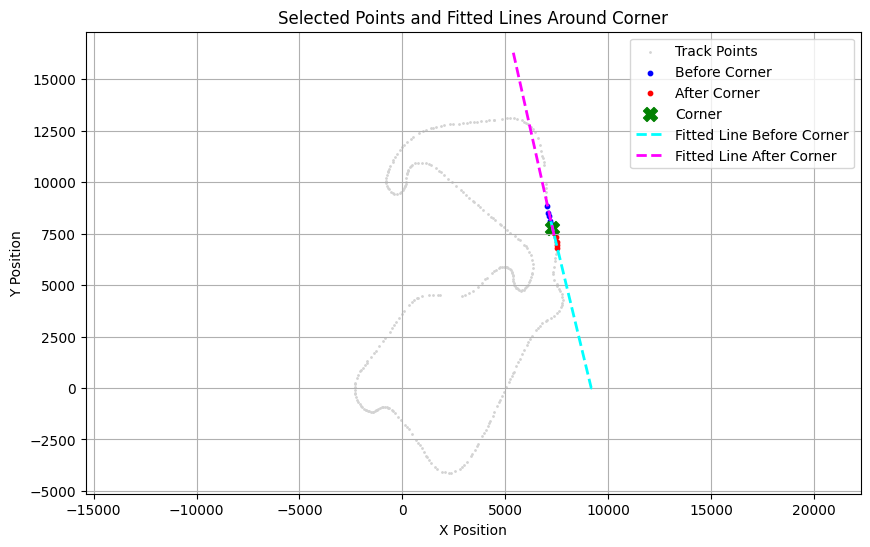

In [329]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(pos['X'], pos['Y'], color='lightgray', s=1, label='Track Points')  # All track points
plt.scatter(before_points['X'], before_points['Y'], color='blue', label='Before Corner', s=10)
plt.scatter(after_points['X'], after_points['Y'], color='red', label='After Corner', s=10)

# Plot the corner point
plt.scatter(corner_x, corner_y, color='green', label='Corner', s=100, marker='X')  # Corner point

print("The acute angle between the two lines is:", acute_angle_degrees, "degrees")
print("The obtuse angle between the two lines is:", obtuse_angle_degrees, "degrees")

# Plot the fitted lines with new colors
plt.plot(x_fit_before, y_fit_before, color='cyan', linestyle='--', linewidth=2, label='Fitted Line Before Corner')
plt.plot(x_fit_after, y_fit_after, color='magenta', linestyle='--', linewidth=2, label='Fitted Line After Corner')

plt.title('Selected Points and Fitted Lines Around Corner')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()